# Apartat (C): Analitzant Dades


In [21]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.stats
import seaborn as sns;
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('data/OnionPrices.csv')
# Eliminem la columna commodity perque es irrelevant
del dataset["commodity"]

dataset.drop(dataset.loc[dataset['max_price'] == 0].index, inplace=True)
dataset.drop(dataset.loc[dataset['min_price'] == 0].index, inplace=True)

#Guardem les noves dades en un csv i les carguem un altre cop
dataset.to_csv("data/OnionPrices_2.csv")
dataset = load_dataset('data/OnionPrices_2.csv')
del dataset["Unnamed: 0"]

data = dataset.values
x = data[:, :]
y_modal_price = data[:, -1]


In [3]:
# Visualitzar les dades
dataset.head() 

,state,district,market,variety,arrival_date,min_price,max_price,modal_price
0,Andhra Pradesh,Kurnool,Kurnool,Local,03/01/2020,1350,4390,3100.000
1,Andhra Pradesh,Kurnool,Kurnool,Local,04/01/2020,1390,4400,3200.000
2,Andhra Pradesh,Kurnool,Kurnool,Local,06/01/2020,1460,5150,4310.000
3,Andhra Pradesh,Kurnool,Kurnool,Local,07/01/2020,2010,5200,4200.000
4,Andhra Pradesh,Kurnool,Kurnool,Local,10/01/2020,1320,4050,3300.000


In [3]:
# Comprova quants valors de cada atribut son únics
print("Numero de mercados:", len(dataset['market'].unique()))
print("Numero de distritos:", len(dataset['district'].unique()))
print("Numero de estados:", len(dataset['state'].unique()))
print("Numero de variedad:", len(dataset['variety'].unique()))

Numero de mercados: 905
Numero de distritos: 315
Numero de estados: 22
Numero de variedad: 21


In [23]:
# Per veure estadístiques dels atributs númerics
dataset.describe()
dataset['arrival_date'] = pd.to_datetime(dataset['arrival_date'])
dataset['month'] = pd.DatetimeIndex(dataset['arrival_date']).month
dataset['day'] = pd.DatetimeIndex(dataset['arrival_date']).day

dataset

,state,district,market,variety,arrival_date,min_price,max_price,modal_price,month,day
0,Andhra Pradesh,Kurnool,Kurnool,Local,2020-03-01,1350,4390,3100.000,3,1
1,Andhra Pradesh,Kurnool,Kurnool,Local,2020-04-01,1390,4400,3200.000,4,1
2,Andhra Pradesh,Kurnool,Kurnool,Local,2020-06-01,1460,5150,4310.000,6,1
3,Andhra Pradesh,Kurnool,Kurnool,Local,2020-07-01,2010,5200,4200.000,7,1
4,Andhra Pradesh,Kurnool,Kurnool,Local,2020-10-01,1320,4050,3300.000,10,1
...,...,...,...,...,...,...,...,...,...,...
107100,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Red,2020-03-09,2200,2300,2250.000,3,9
107101,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Red,2020-04-09,2050,2600,2200.000,4,9
107102,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Red,2020-08-09,2700,2875,2800.000,8,9
107103,West Bengal,Sounth 24 Parganas,Diamond Harbour(South 24-pgs),Red,2020-09-09,2625,2875,2800.000,9,9


In [5]:
# Es transforme l'atribut arrival_time que es un objecte al tipus data
print(dataset.dtypes)

state                   object
district                object
market                  object
variety                 object
arrival_date    datetime64[ns]
min_price                int64
max_price                int64
modal_price            float64
month                    int64
day                      int64
dtype: object


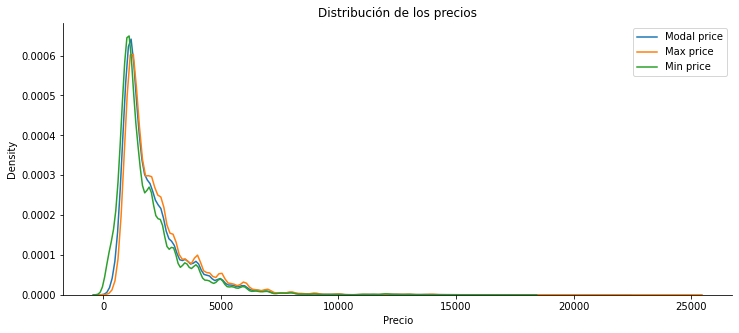

In [5]:
plt.figure(figsize=(12, 5))
sns.kdeplot(data=dataset['modal_price'], label='Modal price')
sns.kdeplot(data=dataset['max_price'], label='Max price')
sns.kdeplot(data=dataset['min_price'], label='Min price' )

plt.title('Distribución de los precios')
plt.xlabel('Precio')
plt.legend()
sns.despine()
plt.show()



També podem estudiar la correlació entre els diferents atributs per tal de saber si estan correlacionats entre ells.

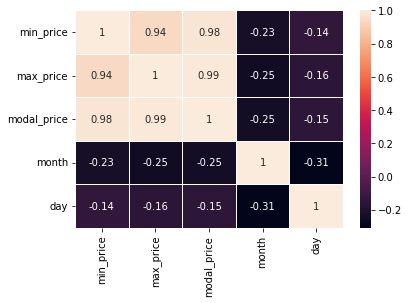

In [7]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dataset.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

També podem utilitzar la funció pairplot per tal de veure els atributs que estan relacionats entre si.

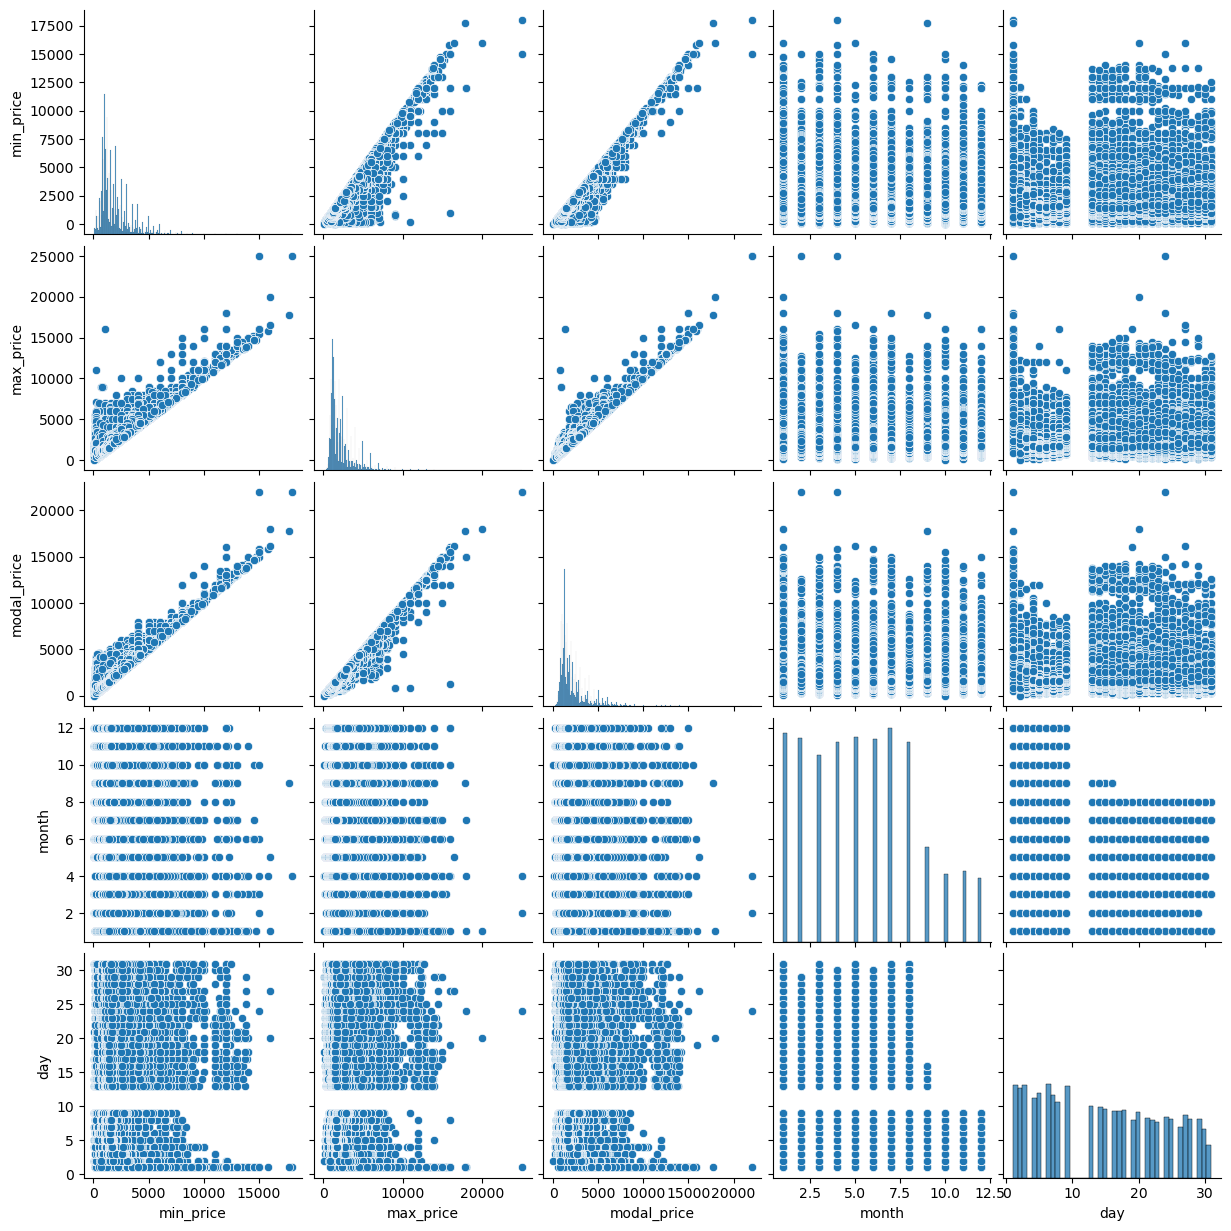

In [8]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset)
plt.savefig("images/correlacio.png", dpi = 300, bbox_inches = 'tight')

Així doncs ara podreu respondre a les següents preguntes:

1. Quin és el tipus de cada atribut?
state                   object
district                object
market                  object
variety                 object
arrival_date    datetime64[ns]
min_price                int64
max_price                int64
modal_price            float64
dtype: object
#Explicar que hemos creado dos atributos mas, que son el mes i el dia
2. Quins atributs tenen una distribució Guassiana?
Cap
3. Quin és l'atribut objectiu? Per què?
Modal price, el más interesente en predecir. 

# Apartat (B): Primeres regressions

Per a aquest primer apartat es calcularà l'error quadràtic mitjà només del regressor per a cada un dels atributs de la base de dades, determinant aquell atribut pel qual l'error quadràtic mitjà (entre el valor predit i el real, per a cada mostra) és més baix. 

A continuació se us dona una funció auxiliar per a calcular l'error quadràtic mitjà:

In [9]:
plt.figure(figsize=(30,10))
plt.title("Histograma de l'atribut 0")
plt.xlabel("Attribute Value")
plt.ylabel("Count")

hist = plt.hist(x[:,-1], bins=len( set(x[:,-1])), rwidth=0.2)
plt.gcf().autofmt_xdate()
plt.savefig("images/histModalPrice.png",dpi = 300, bbox_inches = 'tight')
plt.clf()

for i in range(7):
    plt.title("Histograma de l'atribut ")
    plt.xlabel(dataset.columns[i])
    plt.ylabel("Count")
    hist = plt.hist(x[:,i] , bins=len( set(x[:,i])),  rwidth=0.2)
    plt.gcf().autofmt_xdate()
    plt.savefig("images/histogramas/hist" + dataset.columns[i] + ".png", dpi = 300, bbox_inches = 'tight')
    plt.clf()

<Figure size 3000x1000 with 0 Axes>

In [6]:

train_dataset = dataset
train_dataset.drop(['arrival_date'], axis=1, inplace=True)

train_dataset.head()

,state,district,market,variety,min_price,max_price,modal_price,month,day
0,Andhra Pradesh,Kurnool,Kurnool,Local,1350,4390,3100.000,3,1
1,Andhra Pradesh,Kurnool,Kurnool,Local,1390,4400,3200.000,4,1
2,Andhra Pradesh,Kurnool,Kurnool,Local,1460,5150,4310.000,6,1
3,Andhra Pradesh,Kurnool,Kurnool,Local,2010,5200,4200.000,7,1
4,Andhra Pradesh,Kurnool,Kurnool,Local,1320,4050,3300.000,10,1


In [9]:
train_dataset.shape

(107105, 9)

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer


train_dataset_state_variety = train_dataset[['state','variety', 'min_price', 'max_price', 'month', 'day']]
train_df_x_variety = train_dataset[['variety', 'min_price', 'max_price', 'month', 'day']]
train_df_x_state = train_dataset[['state', 'min_price', 'max_price', 'month', 'day']]
train_df_y = train_dataset['modal_price']

df_x_prices = train_dataset[['min_price', 'max_price']]
df_x_max_price = train_dataset[ 'max_price']


def replace_categorical(df):  
    columns = df.columns
    for col in columns:
        if df[col].dtype == 'object':
            df = pd.concat([df, pd.get_dummies(df[col],prefix=col)], axis=1)
            df = df.drop(columns=col)
    
    return df


train_dataset_state_variety = replace_categorical(train_dataset_state_variety)
train_df_x_variety = replace_categorical(train_df_x_variety)
train_df_x_state = replace_categorical(train_df_x_state)

df_x_prices.head(3)

,min_price,max_price
0,1350,4390
1,1390,4400
2,1460,5150


In [8]:
import math

def mean_squeared_error(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

In [9]:
import numpy as np #importem la llibreria
np.warnings.filterwarnings('ignore')

def mse(v1, v2):
    return ((v1 - v2)**2).mean()


Per a la regressió podeu utilitzar la llibreria sklearn:

In [10]:
from sklearn.linear_model import LinearRegression

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

In [99]:
def standarize(x, mean=None, std=None):
    if mean is None:
        mean = x.mean(0)
    if std is None:
        std = x.std(0)
    
    return (x - mean[None, :]) / std[None, :], mean, std

train_df_x_norm, mean, std = standarize(train_dataset_state_variety.values)
train_df_x_norm_variety, mean, std = standarize(train_df_x_variety.values)
train_df_x_norm_state, mean, std = standarize(train_df_x_state.values)

train_df_y_norm, mean, std = standarize(train_df_y.values[:, None])

df_x_prices_norm, mean, std = standarize(df_x_prices.values)



df_x_prices_norm


array([[-0.37420816,  1.33992296],
       [-0.34679915,  1.34631552],
       [-0.2988334 ,  1.82575731],
       ...,
       [ 0.55084567,  0.37145054],
       [ 0.49945379,  0.37145054],
       [ 0.61936818,  0.38103938]])

<AxesSubplot:>

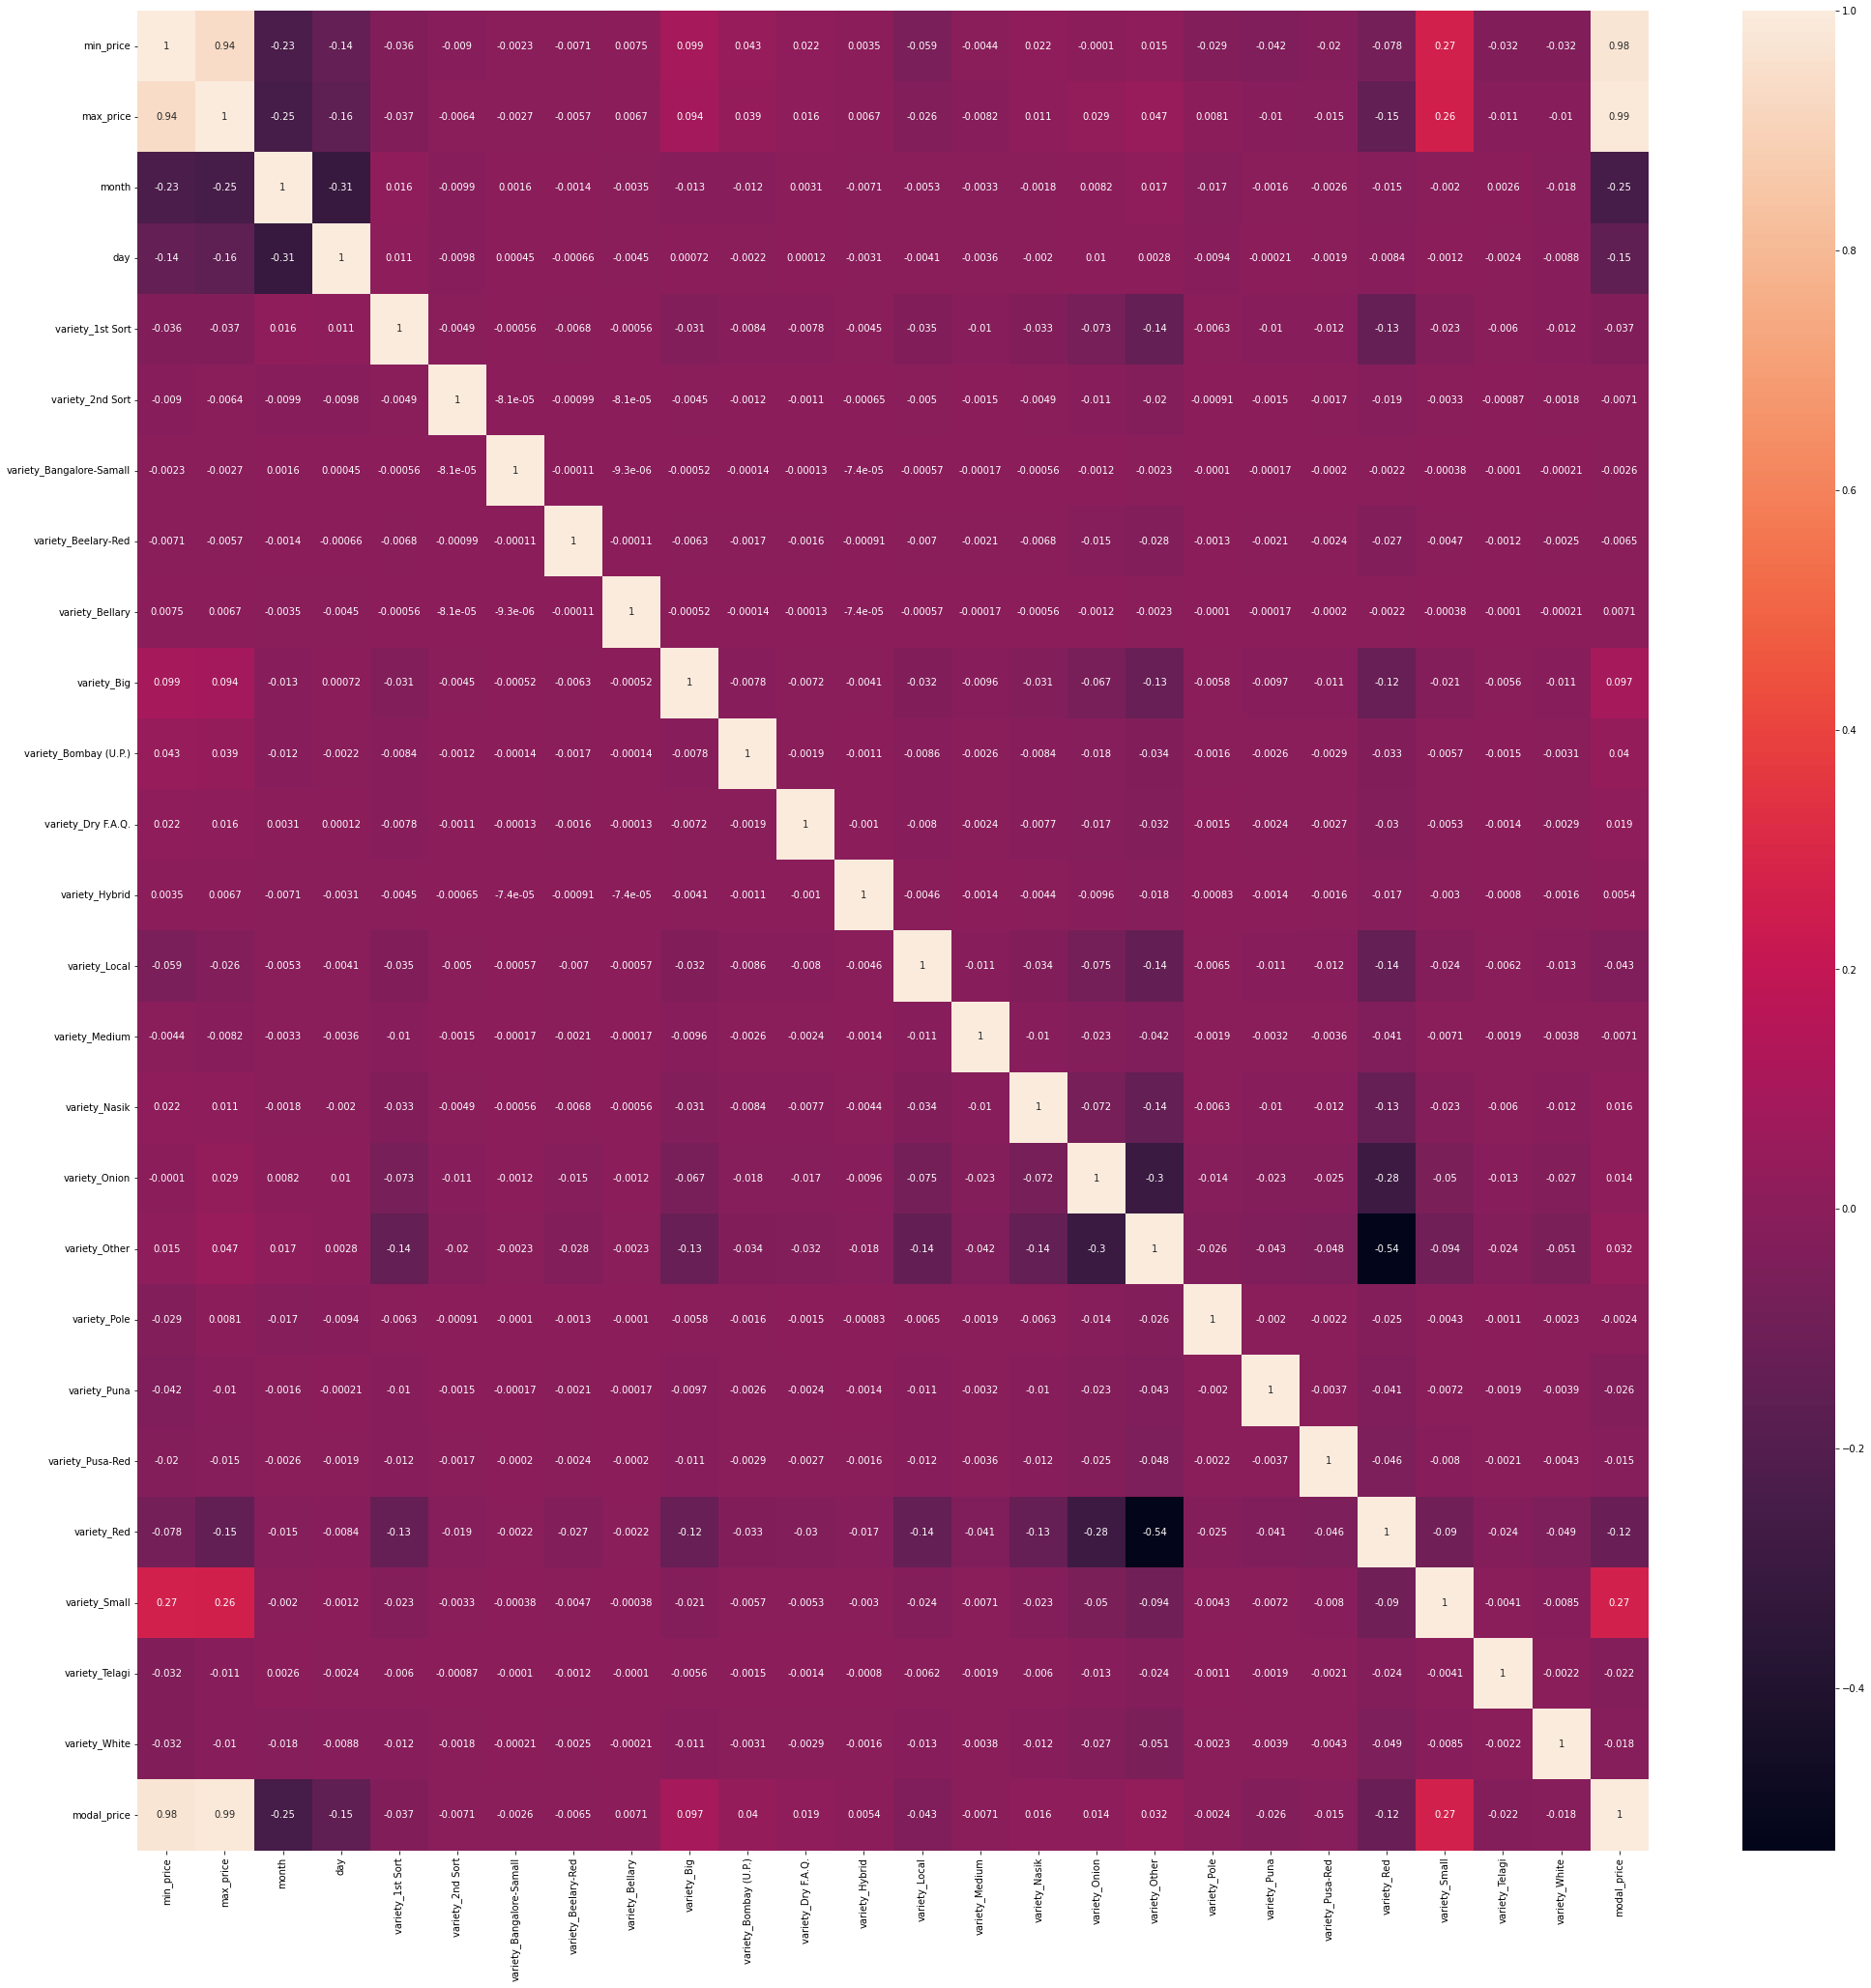

In [17]:
correlation_df_variety_price = pd.concat([train_df_x_variety, train_df_y], axis=1)
f, ax = plt.subplots(figsize=(35,35))
sns.heatmap(correlation_df_variety_price.corr(), annot=True)

<AxesSubplot: >

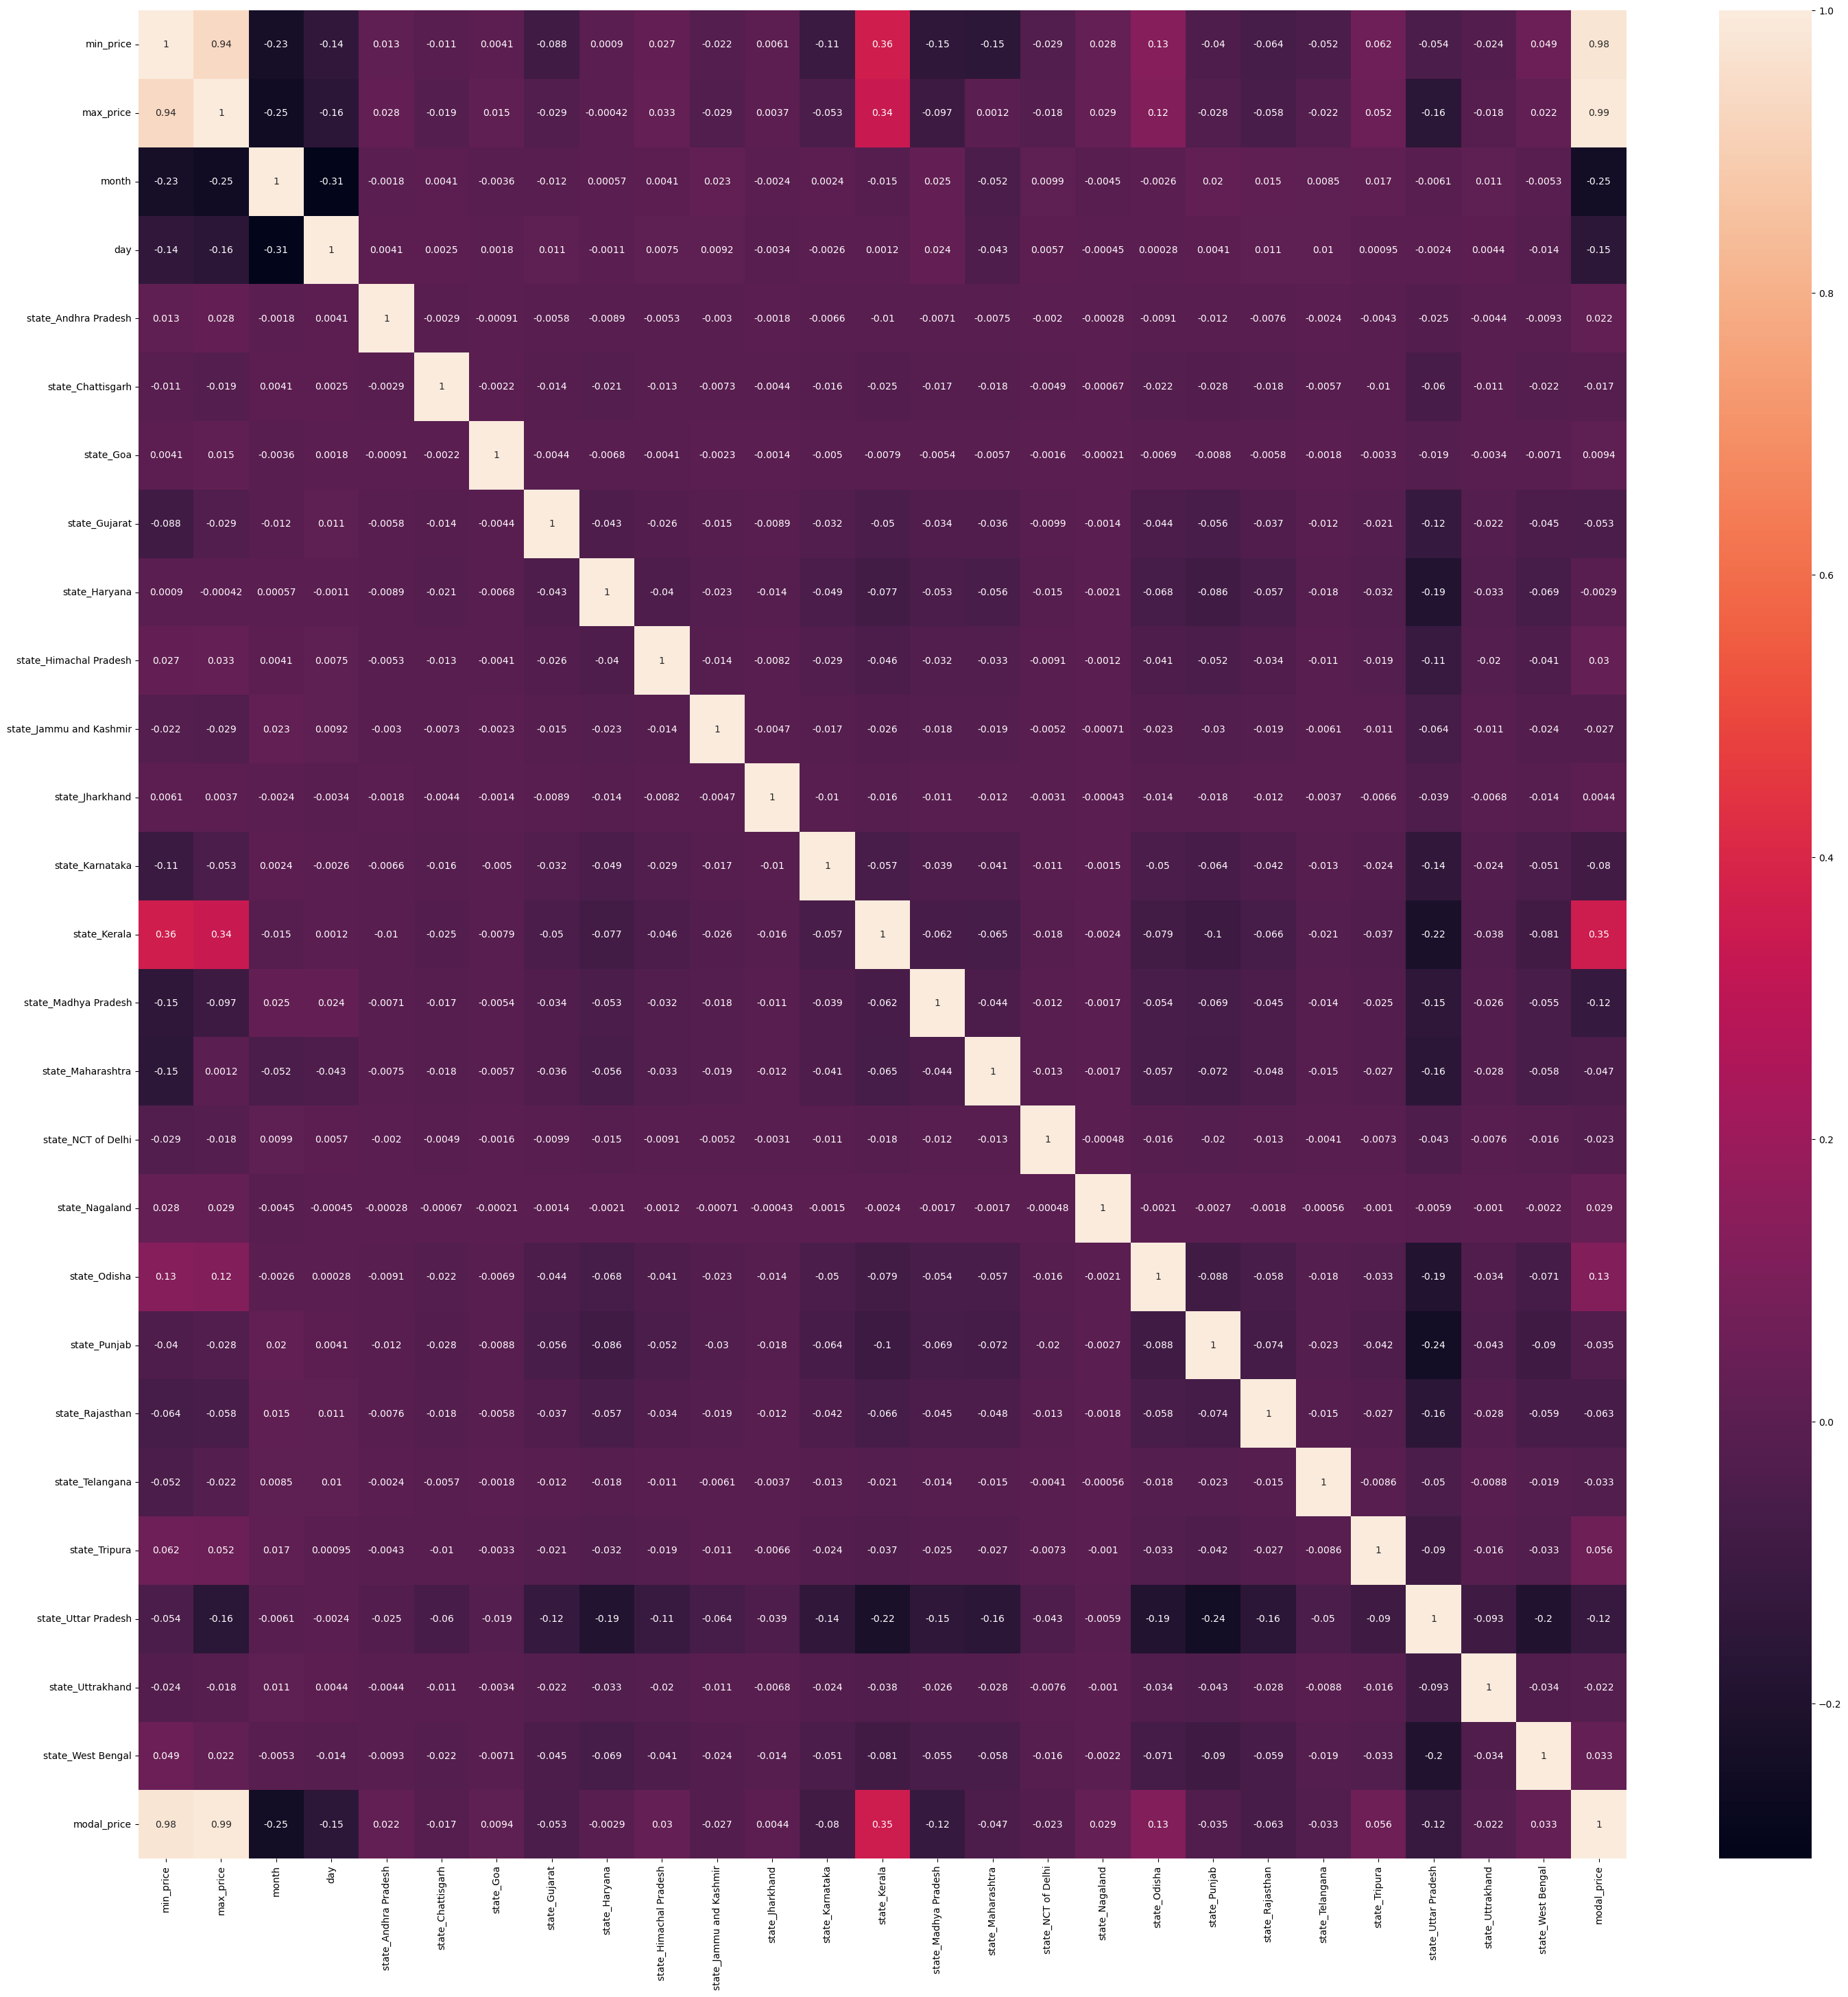

In [77]:
correlation_df_state_price = pd.concat([train_df_x_state, train_df_y], axis=1)
f, ax = plt.subplots(figsize=(35,35))
sns.heatmap(correlation_df_state_price.corr(), annot=True)

Ara ja podeu comprovar la diferència entre entrenar amb els atributs estandaritzats i si aquells que tenen una distribució més semblant a la normal donen millors resultats. 
Finalment, s'aprendrà un model regressor tenint en compte tots aquells atributs que tenen una millor distribució de valors (lineal, això és, l'histograma de valors té forma de gaussiana), i es calcularà l'error assolit en la predicció. 

Recordeu que el valor sobre el que heu de fer la regressió queda al vostre criteri: **heu d'explicar a la memòria quin atribut heu fet servir, no hi ha una decisió única correcta, cal que doneu raons de per què heu triat l'atribut que hàgiu triat.**

Així per exemple pode mirar:

* Que l'objectiu de la regressió sigui un valor ordinal (1 > 2 > 3). Si no n'hi ha cap, explicar-ho a la memòria.

* Que sigui útil en alguna aplicació real (per exemple predir si plourà és més interessant que predir el color dels núvols).

* Que tingui certa variació (un atribut que és sempre 0, no té gaire interès)

I en definitiva explicar el criteri a seguir, tant amb paraules com amb gràfiques (per exemple histograma), o estadístiques (per exemple la variança dels atributs) si escau.

Un cop escollit l'atribut objectiu, caldrà justificar si l'error obtingut és, en proporció, menor que tenint en compte únicament el millor atribut identificat al primer punt. 

Podeu utilitzar les funcions hist de matplotlib per a calcular els histogrames. Exemple:

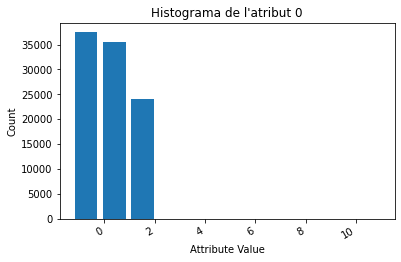

In [18]:
plt.figure()
plt.title("Histograma de l'atribut 0")
plt.xlabel("Attribute Value")
plt.ylabel("Count")

plt.hist(train_df_x_norm[:,3], bins=11, range=[np.min(train_df_x_norm[:,0]), np.max(train_df_x_norm[:,0])], histtype="bar", rwidth=0.8)
plt.gcf().autofmt_xdate()
#plt.savefig("images/hist_standarize" + str(i) + ".png", dpi = 300, bbox_inches = 'tight')
plt.show()

o utilitzar les funcions de visualitzación del propi pandas.

Ara que hem carregat les dades podem entrenar un regressor lineal per a aproximar la funció que les genera:

In [19]:
train_df_y_norm

array([[0.66338973],
       [0.73036101],
       [1.47374221],
       ...,
       [0.46247589],
       [0.46247589],
       [0.50935578]])

In [20]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
mse_array = {}
for k in range(47):
    atribut1 = train_df_x_norm[:,k].reshape(train_df_x_norm.shape[0], 1) 
    regr = regression(atribut1, train_df_y_norm) 
    predicted = regr.predict(atribut1)

    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    #plt.figure()
    #ax = plt.scatter(train_df_x_norm[:,k], train_df_y)
    #plt.plot(atribut1[:,0], predicted, 'r')

    # Mostrem l'error (MSE i R2)
    MSE = mse(train_df_y_norm, predicted)
    mse_array[train_dataset_state_variety.columns[k]] = MSE
    r2 = r2_score(train_df_y_norm, predicted)
    print("============================================")
    print("Col: ", train_dataset_state_variety.columns[k])
    print("Mean squeared error: ", MSE)
    print("R2 score: ", r2)
    print("============================================")



Col:  min_price
Mean squeared error:  0.04910959695840374
R2 score:  0.9508904030415962
Col:  max_price
Mean squeared error:  0.029336368281887952
R2 score:  0.9706636317181121
Col:  month
Mean squeared error:  0.9384451948539462
R2 score:  0.061554805146053715
Col:  day
Mean squeared error:  0.9767166572473728
R2 score:  0.023283342752627112
Col:  state_Andhra Pradesh
Mean squeared error:  0.9995365787591276
R2 score:  0.000463421240872286
Col:  state_Chattisgarh
Mean squeared error:  0.9997037940803277
R2 score:  0.0002962059196721656
Col:  state_Goa
Mean squeared error:  0.9999111913096304
R2 score:  8.880869036953509e-05
Col:  state_Gujarat
Mean squeared error:  0.997150297578186
R2 score:  0.0028497024218138156
Col:  state_Haryana
Mean squeared error:  0.99999164858034
R2 score:  8.351419659824444e-06
Col:  state_Himachal Pradesh
Mean squeared error:  0.9991056952969988
R2 score:  0.0008943047030011142
Col:  state_Jammu and Kashmir
Mean squeared error:  0.9992880997639813
R2 score

In [21]:
mse_array = {}
data_without_norm = train_dataset_state_variety.values[:,:]
for k in range(47):
    atribut1 = data_without_norm[:,k].reshape(data_without_norm.shape[0], 1) 
    regr = regression(atribut1, train_df_y) 
    predicted = regr.predict(atribut1)

    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    #plt.figure()
    #ax = plt.scatter(train_df_x_norm[:,k], train_df_y)
    #plt.plot(atribut1[:,0], predicted, 'r')

    # Mostrem l'error (MSE i R2)
    MSE = mse(data_without_norm, predicted)
    mse_array[train_dataset_state_variety.columns[k]] = MSE
    r2 = r2_score(train_df_y, predicted)
    print("============================================")
    print("Col: ", train_dataset_state_variety.columns[k])
    print("Mean squeared error: ", MSE)
    print("R2 score: ", r2)
    print("============================================")

ValueError: operands could not be broadcast together with shapes (107105,47) (107105,) 

Un cop mostrats de manera adient, (en forma de taula, i/o de gràfics si la dimensionalitat ho permet) els resultats aconseguits amb la regressió, avaluarem de manera independent la idonietat de cadascun dels atributs.

In [14]:
""" Per a assegurar-nos que el model s'ajusta be a dades noves, no vistes, 
cal evaluar-lo en un conjunt de validacio (i un altre de test en situacions reals).
Com que en aquest cas no en tenim, el generarem separant les dades en 
un 80% d'entrenament i un 20% de validació.
"""
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(train_df_x_norm, train_df_y_norm)

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = regression(x_t, y_train)    
    error = mse(y_val, regr.predict(x_v)) # calculem error
    r2 = r2_score(y_val, regr.predict(x_v))

    print("Error en atribut %d: %f" %(i, error))
    print("R2 score en atribut %d: %f" %(i, r2))


Quan es treballa en dades n-dimensionals (més d'un atribut), una opció és reduir la seva n-dimensionalitat aplicant un Principal Component Analysis (PCA) i quedar-se amb els primers 2 o 3 components, obtenint unes dades que (ara sí) poden ser visualitzables en el nou espai. Existeixen altres embeddings de baixa dimensionalitat on poder visualitzar les dades?

In [85]:
{k: v for k, v in sorted(mse_array.items(), key=lambda item: item[1])}

{'max_price': 0.029336368281887938,
 'min_price': 0.049109596958403744,
 'state_Kerala': 0.8756996744565316,
 'variety_Small': 0.928526993317717,
 'month': 0.9384451948539462,
 'day': 0.9767166572473728,
 'state_Odisha': 0.9843498421705835,
 'state_Madhya Pradesh': 0.9845653858187791,
 'state_Uttar Pradesh': 0.9858562325085668,
 'variety_Red': 0.9863956527134728,
 'variety_Big': 0.9906624765014381,
 'state_Karnataka': 0.9935490987097628,
 'state_Rajasthan': 0.9960386422286412,
 'state_Tripura': 0.996864216868121,
 'state_Gujarat': 0.997150297578186,
 'state_Maharashtra': 0.9977963346131513,
 'variety_Local': 0.9981257402375677,
 'variety_Bombay (U.P.)': 0.9984061907337346,
 'variety_1st Sort': 0.998614675827218,
 'state_Punjab': 0.9987973336643474,
 'state_Telangana': 0.9989151169618434,
 'state_West Bengal': 0.9989235430796363,
 'variety_Other': 0.9989464567223513,
 'state_Himachal Pradesh': 0.9991056952969989,
 'state_Nagaland': 0.999148153371848,
 'state_Jammu and Kashmir': 0.999288

Així es podrà contestar a aquestes **preguntes**:

1. Quin són els atributs més importants per fer una bona predicció?
Max_price i min_price,
min_price R2 score:  0.9508904030415962
max_price R2 score:  0.9706636317181121

2. Amb quin atribut s'assoleix un MSE menor?
Amb el max_price amb un max_price: 0.029336368281887938

3. Quina correlació hi ha entre els atributs de la vostra base de dades?
Amb el max_price (99 de relacio), min_price (98 de relació), varierty_small (0.27 de relacio), state_kerala (relacio de 0.35) TODOS SON RELACIONES CON MODAL PRICE

4. Com influeix la normalització en la regressió?

5. Com millora la regressió quan es filtren aquells atributs de les mostres que no contenen informació?

6. Si s'aplica un PCA, a quants components es redueix l'espai? Per què?


# Apartat (A): El descens del gradient  

En aquest exercici, es tracta d'implementar en python el procés de descent del gradient explicat a les classes de teoria, i comparar-lo amb els resultats obtinguts amb l'apartat (B). 

$$J(w) = \frac{1}{2m} \left[ \sum^m_{i=1}(f(x^{i}; w) - y^{i})^2 + \lambda\sum_{j=1}^{n}(w_{j}^2) \right]$$

Fixeu-vos que $J$ retorna el `mse`. Per a trobar $w_j$, repetir fins convergència:
$$w_0 = w_0 - \alpha \frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot 1$$
$$w_j = w_j - \alpha \left[\frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i} - \frac{\lambda}{m}w_{j} \right]$$


ó:

$$w_{j} := w_{j} \left(1-\alpha \frac{\lambda}{m} \right) - \alpha\frac{\lambda}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i}$$

On si considerem un regressor lineal (el model és una recta), llavors $w_0$ i $w_1$ representen, respectivament, la $b$ i $a$ de la fòrmula de la recta: 

$$h_\theta(x^{(i)}) = ax + b$$

$\alpha$ és el learning rate, i $h_\theta(x^{(i)})$ és la funció que fa la regressió, és a dir, la funció que prediu el valor de $y^{(i)}$ donat un(s) atribut(s) concret(s) $x^{(i)}$.

Així, tenint calculat el model en l'últim punt del primer exercici, ja sabeu quin resultat hauríeu d'obtenir. O no, perquè la vostra implementació pot ser millor! En concret, es tracta de desenvolupar aquestes tasques:

* Definir la funció de cost i del gradient

* Estudiar com l'ús de regularitzadors afecta el resultat: overfitting, underfitting, etc. 

* Visualització de les dades a analitzar i explicació pas a pas del procediment   

* Visualització del procés de descens de gradient 

* Modificar el learning rate i el nombre d'iteracions 

<img src="images/gradient_descent.png">

Per a la implementació us podeu basar en el següent esquelet:

In [23]:
class Regressor(object):
    def __init__(self, w0, w1, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.alpha = alpha

        
    def predict(self, x):
        # implementar aqui la funció de prediccio
        pass
    
    def __update(self, hy, y):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        pass
    
    def train(self, max_iter, epsilon):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        pass

L'últim pas serà validar el regressor trobat pel descent del gradient desenvolupat en aquest apartat visualment, aplicat a un model de recta i un model de pla. Per a això, caldrà considerar el millor atribut identificat en el primer punt de l'anterior entrega per visualitzar la línia regressora en 2D (podeu mostrar dades 2d amb la funció scatter). Després, dos dels atributs identificats a l'últim punt del primer exercici per visualitzar el pla regressor en 3D (En el cas 3D l’scatter s’ha de fer sobre una figura amb projecció 3D).

In [39]:
%matplotlib notebook

# Creem figura 3d
from mpl_toolkits.mplot3d import axes3d, Axes3D
# generem dades 3D d'exemple
x_val = np.random.random((100, 2))
y_val = np.random.random((100, 1))
regr = regression(x_val, y_val)
predX3D = regr.predict(x_val)

# Afegim els 1's
A = np.hstack((x_val,np.ones([x_val.shape[0],1])))
w = np.linalg.lstsq(A,predX3D)[0]

#Dibuixem
#1r creem una malla acoplada a la zona de punts per tal de representar el pla
malla = (range(20) + 0 * np.ones(20)) / 10 
malla_x1 =  malla * (max(x_val[:,0]) - min(x_val[:,0]))/2 + min(x_val[:,0])
malla_x2 =  malla * (max(x_val[:,1]) - min(x_val[:,1]))/2 + min(x_val[:,1])

#la funcio meshgrid ens aparella un de malla_x1 amb un de malla_x2, per atot
#element de mallax_1 i per a tot element de malla_x2.
xplot, yplot = np.meshgrid(malla_x1 ,malla_x2)

# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean

#ara creem la superficies que es un pla
zplot = w[0] * xplot + w[1] * yplot + w[2]

#Dibuixem punts i superficie
plt3d = plt.figure('Coeficiente prismatico -- Relacio longitud desplacament 3D', dpi=100.0).gca(projection='3d')
plt3d.plot_surface(xplot,yplot,zplot, color='red')
plt3d.scatter(x_val[:,0],x_val[:,1],y_val)

<IPython.core.display.Javascript object>

In [248]:
import time
from sklearn import linear_model
x_train, y_train, x_val, y_val = split_data(train_df_x_norm, train_df_y_norm)
#x_train, y_train, x_val, y_val = split_data(train_df_x_norm_variety, train_df_y_norm)
#x_train, y_train, x_val, y_val = split_data(train_df_x_norm_state, train_df_y_norm)
t1=time.time()
lm = LinearRegression() 
lm.fit(x_train,y_train)
print("The intercept term of the linear model:", lm.intercept_)
print("The coefficients of the linear model:", lm.coef_)
t2=time.time()
t_sklearn_linear = float(t2-t1)
print("Time taken: {} seconds".format(t_sklearn_linear)) 

The intercept term of the linear model: [1.90233119e+08]
The coefficients of the linear model: [[ 4.54093218e-01  5.58176273e-01 -1.51663066e-03 -6.40640145e-04
   6.00353046e+08  1.43821320e+09  4.58382757e+08  2.84983954e+09
   4.20499726e+09  2.62671809e+09  1.52880638e+09  9.25023612e+08
   3.21683891e+09  4.79823904e+09  3.43631797e+09  3.60502757e+09
   1.02493416e+09  1.41025394e+08  4.29375344e+09  5.24829962e+09
   3.67069051e+09  1.19739138e+09  2.13240339e+09  8.30006674e+09
   2.19974778e+09  4.37818808e+09  2.70595958e+10  4.05896156e+09
   6.27228705e+10  5.68137059e+09  4.65757926e+08  2.51060913e+10
   6.96356561e+09  6.43119060e+09  3.69576877e+09  2.77028418e+10
   8.61217446e+09  2.69092274e+10  5.22957420e+10  7.30586801e+10
   5.22506801e+09  8.67451517e+09  9.70554137e+09  7.21978857e+10
   1.88121242e+10  4.99203846e+09  1.02864283e+10]]
Time taken: 0.21699285507202148 seconds


In [249]:
from sklearn.metrics import mean_squared_error
y_pred = lm.predict(x_val) 


y_d = desnormalitzar(y_val, mean, std)
res = desnormalitzar(y_pred, mean, std)
print(mean_squared_error(y_d,res))

recta_x = np.arange(-1,10,0.2)
print(train_df_y_norm.shape)
print (res[:,1].shape)
print(y_d)
plt.scatter(res[:,1], y_d[:,1], color = "red")

plt.xlabel('valor predit')
plt.ylabel('valor original')
plt.savefig("images/resultats", dpi = 300, bbox_inches = 'tight')
plt.show()

4.434967667909505e+28
(107105, 1)
(21421,)
[[1080.55863215 1419.73469364]
 [1886.88212304 2284.04148104]
 [ 654.42888425  962.96165206]
 ...
 [2106.78852964 2519.76151397]
 [ 948.61478819 1278.30267389]
 [1056.12458698 1393.54357887]]


<IPython.core.display.Javascript object>

In [232]:
import time
# Regressio lineal per min_price i max_price

x_train, y_train, x_val, y_val = split_data(df_x_prices_norm, train_df_y_norm)
t1=time.time()
lm = LinearRegression() 
lm.fit(x_train,y_train)
print("The intercept term of the linear model:", lm.intercept_)
print("The coefficients of the linear model:", lm.coef_)
t2=time.time()
t_sklearn_linear = float(t2-t1)
print("Time taken: {} seconds".format(t_sklearn_linear)) 

The intercept term of the linear model: [-6.39546854e-05]
The coefficients of the linear model: [[0.42817077 0.58367861]]
Time taken: 0.011000871658325195 seconds


In [233]:
from sklearn.metrics import mean_squared_error
y_pred = lm.predict(x_val) 


y_d = desnormalitzar(y_val, mean, std)
res = desnormalitzar(y_pred, mean, std)
print(mean_squared_error(y_d,res))

recta_x = np.arange(-1,10,0.2)
print(train_df_y_norm.shape)
print (res[:,1].shape)
print(y_d)
plt.scatter(y_pred, y_val, color = "red")
plt.plot(recta_x, recta_x, color = "green")
plt.xlabel('valor predit')
plt.ylabel('valor original')
plt.savefig("images/resultats", dpi = 300, bbox_inches = 'tight')
plt.show()


14643.093407653756
(107105, 1)
(21421,)
[[ 762.91604484 1079.25020164]
 [5698.59317085 6369.85538512]
 [1300.46503876 1655.45472657]
 ...
 [ 811.78413519 1131.63243118]
 [ 924.18074301 1252.11155912]
 [3670.56742105 4195.99285923]]


<IPython.core.display.Javascript object>

Així es podrà contestar a aquestes preguntes:

1. Com influeixen tots els paràmetres en el procés de descens? Quins valors de learning rate convergeixen més ràpid a la solució òptima? Com influeix la inicialització del model en el resultat final? 



2. Quines funcions polinomials (de diferent grau, de diferents combinacions d'atributs, ...) heu escollit per ser apreses amb el vostre descens del gradient? quina ha donat el millor resultat (en error i rapidesa en convergència)?

Hem provat 4 combinacions. Primer sol utilitzem el min_price i el max_price, en aquesta prova dona un mse més elevat, aproximadament 18000 que eliminant l'elevat dona una mitja de 134 d'error a les prediccions.

Considerant que els valors del preu normalment oscil·len entre 500 i 4000 (sense considerar valors extrems) és un error assequible.

Les següents proves van donar resultats similars, les proves van ser amb min_price, max_price i els valors de variety. Després amb min_price, max_price i els valors de states. Per últim amb min_price, max_price, valors de states i els valors de variety.
En les 3 últimes proves els resultats variaven molt segons l'execució del model, a vegades donava un mse de 13000-17000 i altres vegades donaven de 0,5-10.

En aquests casos milloraven els resultats respecte a la primera combinació, sobretot en el cas del mse menor que 10, que suposa un error de 3,16. Que considerant el nostre cas és un error pràcticament nul.


3. Utilitzeu el regularitzador en la fòrmula de funció de cost i descens del gradient i proveu polinomis de diferent grau. Com afecta el valor del regularitzador?

3. Quina diferència (quantitativa i qualitativa) hi ha entre el vostre regressor i el de la llibreria ?

4. Té sentit el model (polinomial) trobat quan es visualitza sobre les dades? 

5. Ajuda la visualització a identificar aquelles mostres per a les que el regressor obté els pitjors resultats de predicció? 
